# Оглавление
**Listener** - программа, что переводит записанное вами аудио на микрофон/диктофон в набор нот, после чего накладывает их на нотный стан, с точностью до длительности.

**Данный файл** предназначен для ознакомления программиста со структурой библиотек librosa, numpy, и для изучения основ работы со звуком и физики звука.

Текущие задачи:
    - Научиться определять ноту, созвучную с гармоникой другой ноты от двух созвучных гармоник (обертонов)
    - Научиться определять ноту по её обертонам
    - Структурировать уже существующий код

Импорт необходимых библиотек:

In [169]:
import librosa
import numpy as np
import librosa.display
from matplotlib import  pyplot as plt

Загрузка файла и вывод основной информации.

In [171]:
audio_filename = 'a.wav'
sampling_rate = 48000
audio_file , sampling_rate = librosa.load(audio_filename,sr = sampling_rate)
print('Audio file type :', type(audio_file), '; Sample Rate type:', type(sampling_rate))
print('Audio file Shape:', audio_file.shape, '; Sample Rate =', sampling_rate)

duration = audio_file.shape[0]/sampling_rate
min = int(duration/60)
sec = int(duration-min*60)
print('Duration - {}:{}'.format(min,sec))

Audio file type : <class 'numpy.ndarray'> ; Sample Rate type: <class 'int'>
Audio file Shape: (3698400,) ; Sample Rate = 48000
Duration - 1:17


---  
Отрезаю лишь нужную часть аудио для текущей обработки, либо работаю с целым файлом.

In [172]:
start_sec = 2
start_timestamp = int(sampling_rate*start_sec)
ln = 7
end_timestamp = int(start_timestamp + sampling_rate*ln)
# stft = librosa.stft(audio_file[start_timestamp:end_timestamp])
stft= librosa.stft(audio_file)

Перевожу имеющиеся амплитудные данные в  Спектрограмму.

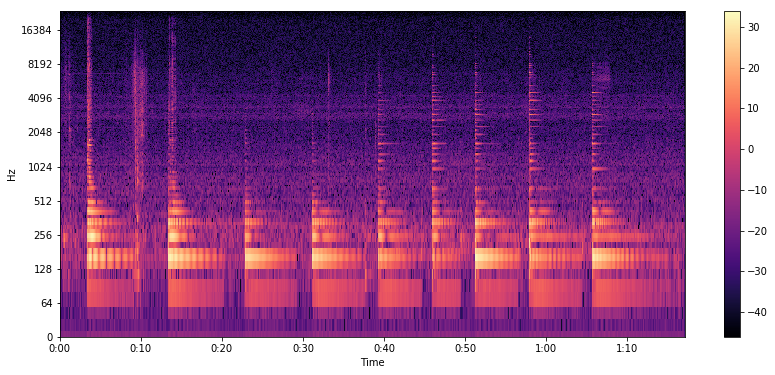

In [173]:
db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
plt.axis([0,96,0,1000])
librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

Пока-что очисткой от шумов будем считать удаление всех тех ячееек, где децибелы отрицательны

In [174]:
db[db < 0] = 0

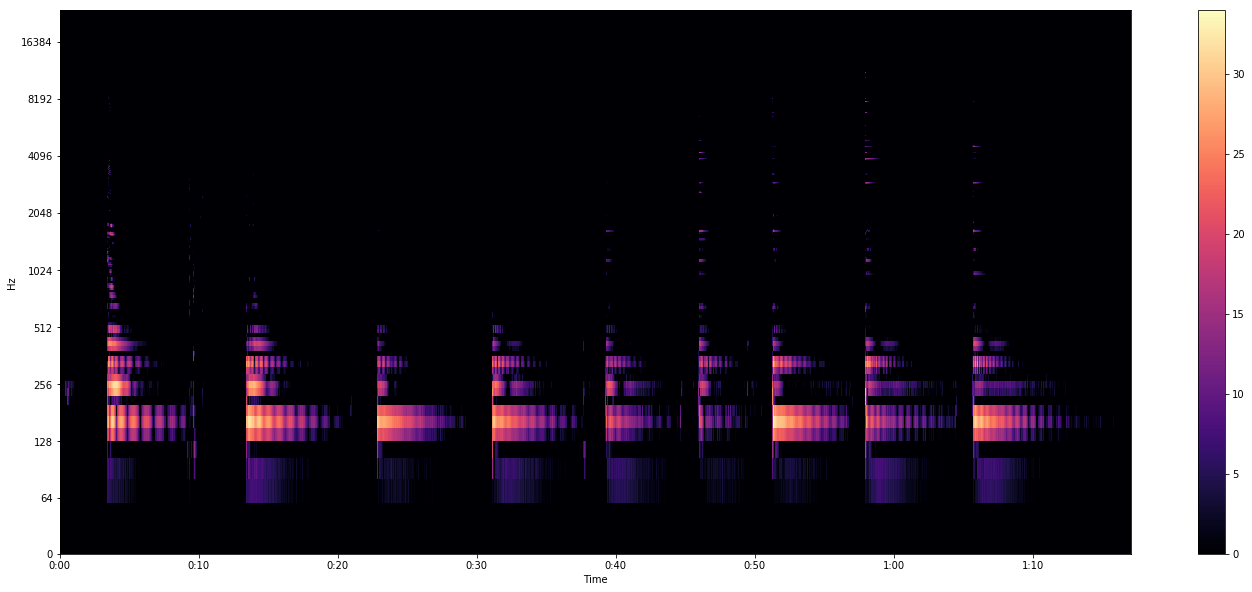

In [175]:
plt.figure(figsize=(24, 10))
librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

In [176]:
db_transposed = db.transpose()
hz_scale = librosa.display.__mesh_coords('log',None,db.shape[0])

Далее генерируется массив, являющийся производной для предыдущей спектрограммы по децибелам.

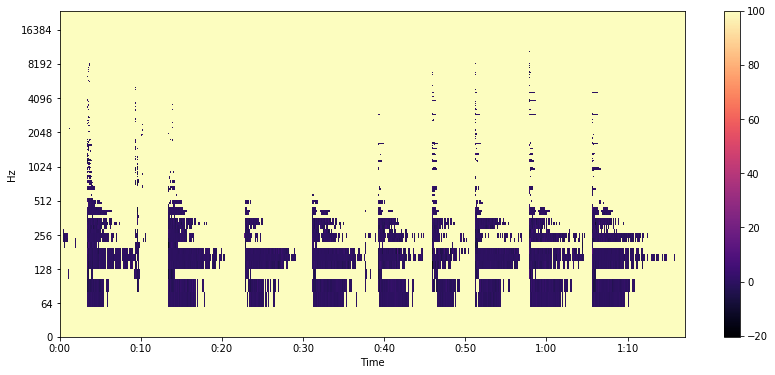

In [177]:
derivative = []
for time in range(len(db_transposed)-1):
    derivative.append([])
    for hz in range(len(db_transposed[time])):
        if db_transposed[time][hz] == 0:
            derivative[time].append(100)
        else:
            derivative[time].append(db_transposed[time+1][hz] - db_transposed[time][hz])
        
derivative = np.array(derivative)
derivative = derivative.transpose()

plt.figure(figsize=(14, 6))
plt.axis([0,96,0,1000])
librosa.display.specshow(derivative,sr = sampling_rate, x_axis = 'time',y_axis = 'log')
plt.colorbar()

Следующий код находит все найденные звуки, но пока не производит очистки ноты от "окрестностей" по частоте, для более точного определения ноты.

Закомментирован за объёмностью выводимых данных

In [133]:
# hertz_list = []
# infinum = 0
# supremum = 50
# for time in range(len(derivative)):
#     for hertz in range(len(derivative[time])):
#         if derivative[time][hertz] > infinum and derivative[time][hertz] < supremum:
#             hertz_list.append([time,hertz])

# for time,hertz in hertz_list:
#     print('Hz = {:.2f}; derivative = {:.2f}; Time = {:.2f} sec'.format(hz_scale[hertz],derivative[time][hertz],time/430*10))

328.38Hz on 31-th floor


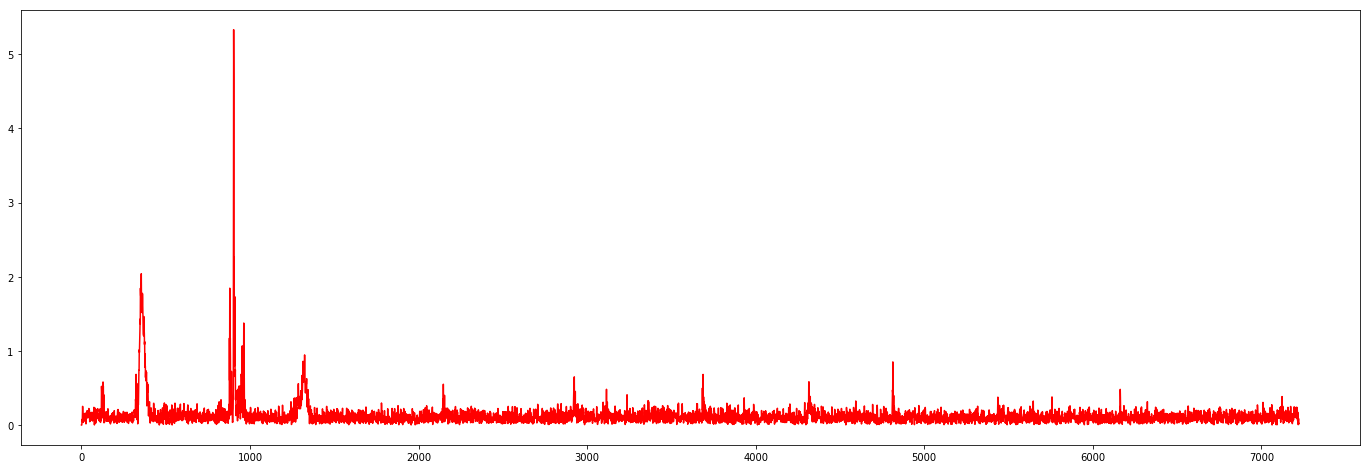

In [182]:
y = 31
print('{:.2f}Hz on {}-th floor'.format(hz_scale[y],y))
angles = np.angle(stft[y])
amplitudes = np.abs(stft[y])
plt.figure(figsize = (24,8))
plt.plot(amplitudes, '-r')

Программист выражает крайнее недовольство связанное с практическим(+-) отсутствием каких либо признаков жизни в р-не одного из обертонов = 4X для 6-й струны(толстой)

---

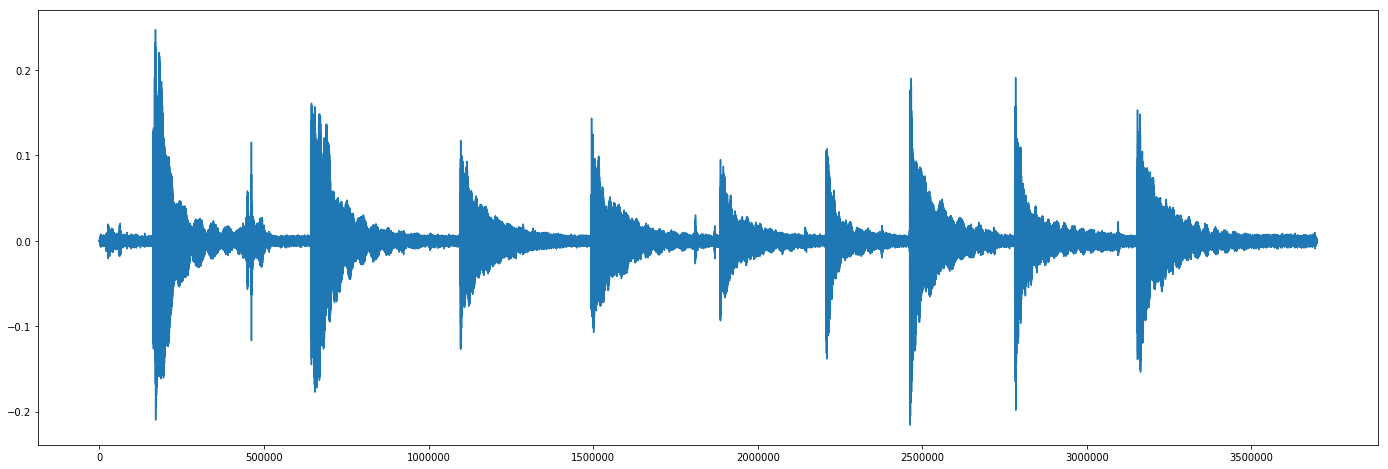

In [181]:
plt.figure(figsize=(24, 8))
# plt.plot(audio_file[start_timestamp:end_timestamp])
plt.plot(audio_file)

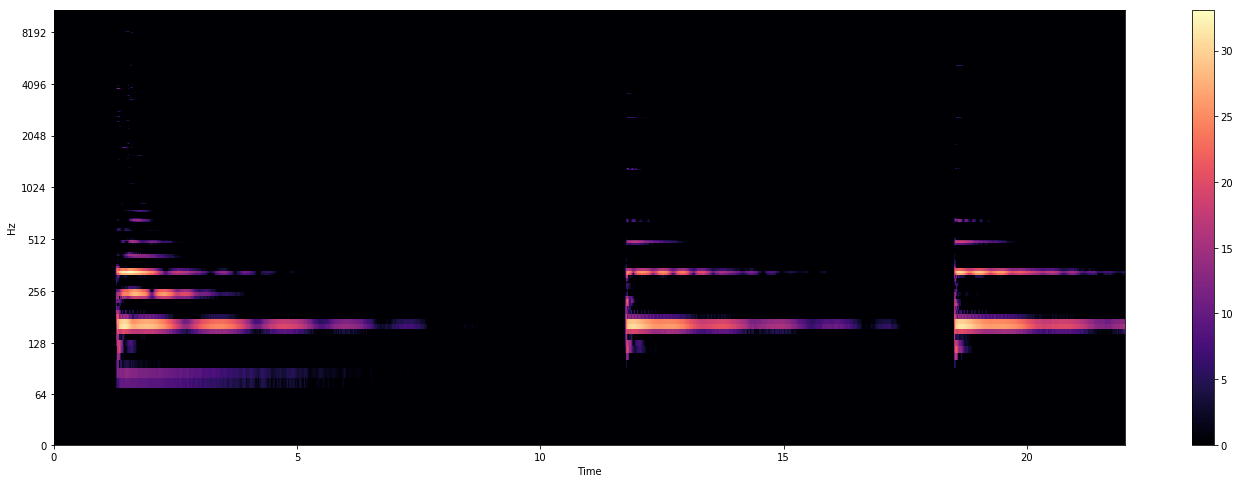

In [23]:
plt.figure(figsize=(24, 8))
librosa.display.specshow(db, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()

Примечания программиста:
    - Чистая нота даёт ровные обертона не отличающиеся по децибелам на спектрограммах
    - Когда параллельно с одной нотой (А-Hz) звучит ещё одна (B-Hz), совпадающая с одним из обертонов(B =n*A), то, видимо, имеет место интерференция двух волн одинаковой длины, т.к. децибелы из плавно убывающих становятся синусоидальными
    - В силу пункта два в случае, к примеру звучания нот A-Hz и 2A-Hz возникнет обертон "с двух сторон" 4A-Hz, что так-же будет иметь синусоидальную в децибелах форму, не давая понять была ли она сыграна, или нет
    - Требуется дополнительное изучение природы, чтобы научиться отличать между собой множество нот из одной гармоники